# Image sharpness and finding the focus point

This notebook illustrates how to find the focus point of an imaging detector by computing the image sharpness as a function of camera position.

In [1]:
import scipp as sc
from ess import imaging as img
from ess.tbl import data
import scippnexus as sx
import numpy as np

## Load the data

We load the image data, and attach the camera stage position to the data array.

In [2]:
dg = sx.load(data.tbl_orca_focussing_data())
da = dg["entry"]["instrument"]["orca_detector"]["data"]
da.coords["position"] = dg["entry"]["instrument"]["camera_stage"]["position_setpoint"][
    "value"
].data
da = da.rename_dims(time="position")
da

Unzipping contents of '/home/runner/.cache/ess/tbl/tbl-orca-focussing.hdf.zip' to '/home/runner/.cache/ess/tbl/tbl-orca-focussing.hdf.zip.unzip'


<scipp.DataArray>
Dimensions: Sizes[position:61, dim_1:512, dim_2:512, ]
Coordinates:
* position                  float64             [mm]  (position)  [140, 141, ..., 199, 200]
* time                    datetime64             [ns]  (position)  [2025-06-11T10:07:14.603685891, 2025-06-11T10:07:19.443681068, ..., 2025-06-11T10:12:15.939916263, 2025-06-11T10:12:20.779694055]
Data:
                              int32  [dimensionless]  (position, dim_1, dim_2)  [30213, 31248, ..., 7737, 7818]

The data contains 61 images, one for each camera position.

We can plot the first image in the sequence to get an impression of what it looks like:

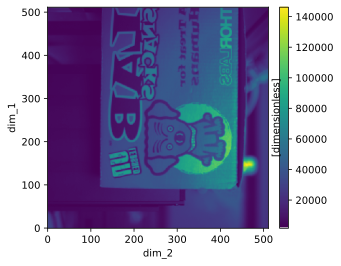

In [3]:
da["position", 0].plot(aspect="equal")

## Computing image sharpness

The `ess.imaging.tools` module provides tools for image manipulation.
The `sharpness` function computes image sharpness over two spatial dimensions (that need to be specified).
The remaining `position` dimension will remain in the output.

In [4]:
sharp = img.tools.sharpness(da, dims=["dim_1", "dim_2"])
sharp

<scipp.DataArray>
Dimensions: Sizes[position:61, ]
Coordinates:
* position                  float64             [mm]  (position)  [140, 141, ..., 199, 200]
* time                    datetime64             [ns]  (position)  [2025-06-11T10:07:14.603685891, 2025-06-11T10:07:19.443681068, ..., 2025-06-11T10:12:15.939916263, 2025-06-11T10:12:20.779694055]
Data:
                            float64  [dimensionless]  (position)  [1.66368e+08, 1.73721e+08, ..., 3.63585e+08, 3.59171e+08]

A simple plot of the sharpness reveals a 'best position' where the sharpness peaks (around 180 mm):

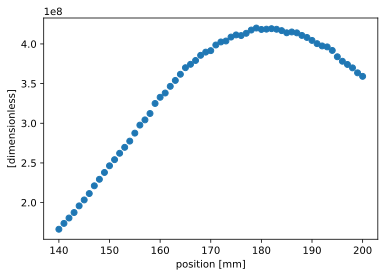

In [5]:
fig = sharp.plot()
fig

## Find the sharpest image

To accurately find the sharpest image, and the associated camera stage position with the best focus,
we filter outliers by applying a 75th percentile threshold to the data.
We then compute the mean position weighted by the sharpness on the remaining points.

In [6]:
threshold = sc.scalar(np.percentile(sharp.values, 75))
sel = sharp.data >= threshold
subset = sharp[sel]
subset

<scipp.DataArray>
Dimensions: Sizes[position:16, ]
Coordinates:
* position                  float64             [mm]  (position)  [174, 175, ..., 188, 189]
* time                    datetime64             [ns]  (position)  [2025-06-11T10:10:05.835713180, 2025-06-11T10:10:10.679685428, ..., 2025-06-11T10:11:18.375689596, 2025-06-11T10:11:23.247713489]
Data:
                            float64  [dimensionless]  (position)  [4.08686e+08, 4.11394e+08, ..., 4.10766e+08, 4.08197e+08]

In [7]:
# Compute weighted mean of selected points
pos = (subset.coords["position"] * subset.data).sum() / subset.data.sum()
pos

<scipp.Variable> ()    float64             [mm]  181.5

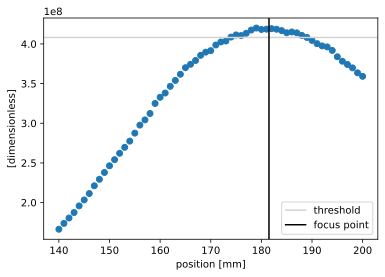

In [8]:
fig.ax.axhline(threshold.value, color="lightgray", label="threshold")
fig.ax.axvline(pos.value, color="k", label="focus point")
fig.ax.legend()
fig

## Image comparison

Finally, we can quickly compare the first image in the stack to the sharpest image determined above.

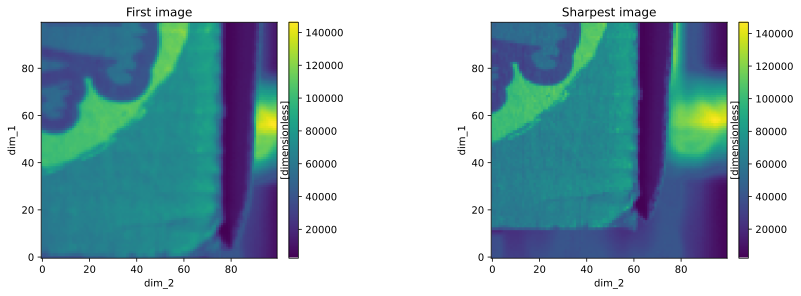

In [9]:
# Show a smaller region to highlight details
dx = 100
xslice = ("dim_2", slice(363, 363 + dx))
yslice = ("dim_1", slice(90, 90 + dx))

# Find the closest position to the focus point
closest = subset.coords["position"][
    np.argmin(sc.abs(subset.coords["position"] - pos).values)
]

da["position", 0][xslice][yslice].plot(aspect="equal", title="First image") + da[
    "position", closest
][xslice][yslice].plot(aspect="equal", title="Sharpest image")